# Outbreaks

Exploratory stuff to figure out how best to define "outbreak"


In [1]:
# init

from matplotlib import pyplot
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

from covid19stats.common import *

conn = get_db_conn()

sns.set(style="darkgrid")

In [2]:
# What's the distribution of Confirmed cases?

sql = """
select
    CASE
        WHEN Confirmed IS NULL OR Confirmed = 0 THEN 0
        WHEN Confirmed <= 100 THEN 100
        WHEN Confirmed <= 200 THEN 200
        WHEN Confirmed <= 300 THEN 300
        WHEN Confirmed <= 400 THEN 400
        WHEN Confirmed <= 500 THEN 500
        WHEN Confirmed <= 600 THEN 600
        WHEN Confirmed <= 700 THEN 700
        WHEN Confirmed <= 800 THEN 800
        WHEN Confirmed <= 900 THEN 900
        WHEN Confirmed <= 1000 THEN 1000
        WHEN Confirmed <= 5000 THEN 5000
        WHEN Confirmed <= 10000 THEN 10000
        ELSE 100000
    END
    AS UpperLimit
    ,Confirmed
    ,1 as Testo
from fact_counties_progress
WHERE 
    Date = (select max(Date) from fact_counties_progress)
    and TwoWeekAvg7DayConfirmedIncreasePct > 1.0
"""

df = psql.read_sql(sql, conn)

# show counts using our custom field, to sanity check the distplot
df.groupby('upperlimit').upperlimit.value_counts()

upperlimit  upperlimit
100         100           102
200         200           106
300         300            86
400         400            57
500         500            55
600         600            37
700         700            25
800         800            23
900         900            20
1000        1000           14
5000        5000          129
10000       10000          16
100000      100000         19
Name: upperlimit, dtype: int64

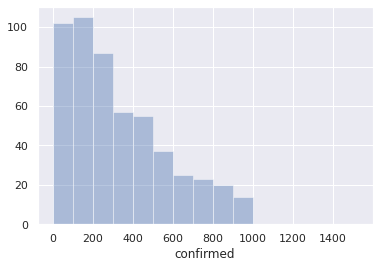

In [3]:
# this should match counts above

s = sns.distplot(
    df['confirmed'],\
    bins=[0, 100,200,300,400,500,600,700,800,900,1000],\
    kde=False)

In [4]:
# WA State uses measure of less than 25 cases per 100,000 in a two week period
# to determine readiness for reopening

sql = """
with t as (
    select 
        State
        ,SUM(CASE WHEN CasesPer100k < 25 THEN 1 ELSE 0 END) as LessThan25
        ,COUNT(*) as NumCounties
    from fact_counties_progress a 
    join dim_county dc 
        on a.fips = dc.fips
        and a.date = (select max(Date) from fact_counties_progress)
    group by state
)
select
    *
    ,cast(LessThan25 as real) / NumCounties as CountiesPct
from t;
"""

df = psql.read_sql(sql, conn)

df

,state,lessthan25,numcounties,countiespct
0,Alabama,0,67,0.000000
1,Alaska,3,28,0.107143
2,Arizona,0,15,0.000000
3,Arkansas,0,75,0.000000
4,California,3,58,0.051724
5,Colorado,5,64,0.078125
6,Connecticut,0,8,0.000000
7,Delaware,0,3,0.000000
8,Diamond Princess,1,1,1.000000
9,District of Columbia,0,1,0.000000


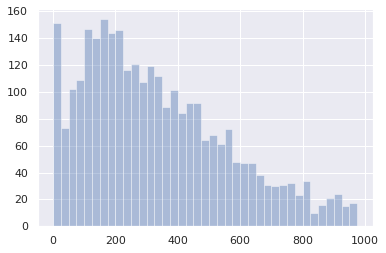

In [5]:
# What's the distribution of CasesPer100k measure?

sql = """
    select 
        CasesPer100k
    from fact_counties_progress a 
    join dim_county dc 
        on a.fips = dc.fips
        and a.date = (select max(Date) from fact_counties_progress)
"""

df = psql.read_sql(sql, conn)

s = sns.distplot(
    df,\
    bins=range(0,1000,25),\
    kde=False)

In [6]:
#print(df.quantile(0.2, interpolation='nearest'))

#print(df.median())

pd.cut(df['casesper100k'], 5, retbins=True)[1]

#df[df['CasesPer100k'] < 0]

#

array([  -10.99840603,  2199.68120562,  4399.36241124,  6599.04361687,
        8798.72482249, 10998.40602811])